In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [2]:
SR=22050
N_MFCC=40
N_MELS=128
DURATION=1
SAMPLES_PER_TRACK=SR*DURATION
CLASSES=['AR','Sniper','nogun']

In [3]:
dataset = pd.read_csv('dataset1.csv')

In [4]:


# def extract_mfcc(audio_path, n_mfcc=13):
#     y, sr = librosa.load(audio_path)
#     mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
#     return np.mean(mfcc, axis=1) 

def extract_features(file_path):
    y,sr=librosa.load(file_path,sr=SR,duration=DURATION)
    if len(y)<SAMPLES_PER_TRACK:
        y=np.pad(y,(0,SAMPLES_PER_TRACK-len(y)))
    else:
        y=y[:SAMPLES_PER_TRACK]
    mfcc=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=N_MFCC)
    mfcc=librosa.util.fix_length(mfcc,size=174,axis=1)
    mfcc=mfcc[...,np.newaxis]

    mel_spec=librosa.feature.melspectrogram(y=y,sr=sr)
    mel_spec=librosa.power_to_db(mel_spec,ref=np.max)
    # plt.figure(figsize=(10,6))
    # librosa.display.specshow(mel_spec,sr=SR,x_axis='time',y_axis='mel')
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('Mel-Spectogram')
    # plt.tight_layout()
    # plt.show()
    mel_spec=librosa.util.fix_length(mel_spec,size=174,axis=1)
    mel_spec=mel_spec[...,np.newaxis]
    return mfcc,mel_spec


# audio_features_melspec = []
# audio_features_mfcc=[]

# for audio_file in os.listdir(audio_dir):
#     if audio_file.endswith('.wav'):
#         audio_path = os.path.join(audio_dir, audio_file)
#         mfcc_features,melspec_features = extract_features(audio_path)
#         audio_features_mfcc.append([audio_file] + mfcc_features.tolist())
#         audio_features_melspec.append([audio_file]+melspec_features.tolist())



In [5]:
def load_dataset(dataset_path):
    x_mfcc,x_melspec,gun_type,direction,distance=[],[],[],[],[]
    suffixes=['_gain.wav','_pan.wav','_pitch.wav','_reverse.wav','_speed.wav','_noise.wav','_original.wav']
    for i,class_name in enumerate(CLASSES):
        class_dir=os.path.join(dataset_path,class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith(".wav"):
                file_path=os.path.join(class_dir,file_name)
                mfcc,mel_spec=extract_features(file_path)
                x_mfcc.append(mfcc)
                x_melspec.append(mel_spec)
                if class_name=='Sniper':
                    for suffix in suffixes:
                        if file_name.endswith(suffix):
                            file_name=file_name[:-len(suffix)]+'.wav'
                gun_type.append(i)
                if class_name=='nogun':
                    direction.append('None')
                    distance.append('None')
                else:
                    row=dataset[dataset['name']==file_name]
                    direction.append(row['dire'].values[0])
                    distance.append(row['dist'].values[0])
    x_mfcc=np.array(x_mfcc)
    x_melspec=np.array(x_melspec)
    gun_encoder=LabelEncoder()
    gun_types_encoded=gun_encoder.fit_transform(gun_type)
    gun_types_categorical=to_categorical(gun_types_encoded)
    gun_types_categorical=np.array(gun_types_categorical)
    direction_encoder=LabelEncoder()
    direction_types_encoded=direction_encoder.fit_transform(direction)
    direction_types_categorical=to_categorical(direction_types_encoded)
    direction_types_categorical=np.array(direction_types_categorical)
    distance_encoder=LabelEncoder()
    distance_types_encoded=distance_encoder.fit_transform(distance)
    distance_types_categorical=to_categorical(distance_types_encoded)
    distance_types_categorical=np.array(distance_types_categorical)
    return x_mfcc,x_melspec,gun_types_categorical,direction_types_categorical,distance_types_categorical


In [6]:
X_mfcc,X_melspec,y_gun,y_direction,y_distance=load_dataset('gun_sound_v9')

In [7]:
X_melspec_shape=X_melspec.shape
X_melspec_shape

(2807, 128, 174, 1)

In [8]:
X_mfcc_shape=X_mfcc.shape
X_mfcc_shape

(2807, 40, 174, 1)

In [9]:
y_gun.shape

(2807, 3)

In [10]:
y_direction.shape

(2807, 6)

In [112]:
X_mfcc_train, X_mfcc_test, X_melspec_train, X_melspec_test, y_gun_train, y_gun_test,y_distance_train,y_distance_test,y_direction_train,y_direction_test = train_test_split(
    X_mfcc, X_melspec, y_gun,y_distance,y_direction,test_size=0.3, random_state=42
)

# Then, split the training+validation set into training and validation sets
# X_mfcc_train, X_mfcc_val, X_melspec_train, X_melspec_val, y_gun_train, y_gun_val,y_distance_train,y_distance_val,y_direction_train,y_direction_val = train_test_split(
#     X_mfcc_trainval, X_melspec_trainval, y_gun_trainval,y_distance_trainval,y_direction_trainval, test_size=0.3, random_state=42
# )

In [113]:
y_gun_train=np.array(y_gun_train)
y_gun_train.shape

(1964, 3)

In [114]:
X_mfcc_test.shape

(843, 40, 174, 1)

In [121]:
import tensorflow as tf
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, Input, Add, SeparableConv2D, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Residual Block
def residual_block(input_tensor, filters, kernel_size=(3, 3), strides=(1, 1)):
    x = SeparableConv2D(filters, kernel_size, activation='relu', padding='same')(input_tensor)
    x = SeparableConv2D(filters, kernel_size, activation='relu', padding='same')(x)
    shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(input_tensor)
    return Add()([x, shortcut])

def create_model(input_shape_mfcc, input_shape_melspec, num_classes=3, num_directions=6, num_distances=7):
    input_mfcc = Input(shape=input_shape_mfcc, name='mfcc_input')
    x_mfcc = residual_block(input_mfcc, filters=16)  # Reduced filters to speed up
    x_mfcc = MaxPooling2D(pool_size=(2, 2))(x_mfcc)
    x_mfcc = Dropout(0.2)(x_mfcc)  # Reduced dropout
    x_mfcc = residual_block(x_mfcc, filters=32)
    x_mfcc = GlobalAveragePooling2D()(x_mfcc)

    input_melspec = Input(shape=input_shape_melspec, name='melspec_input')
    x_melspec = residual_block(input_melspec, filters=16)  # Reduced filters
    x_melspec = MaxPooling2D(pool_size=(2, 2))(x_melspec)
    x_melspec = Dropout(0.2)(x_melspec)  # Reduced dropout
    x_melspec = residual_block(x_melspec, filters=32)
    x_melspec = GlobalAveragePooling2D()(x_melspec)

    # Concatenate Features
    concatenated = concatenate([x_mfcc, x_melspec])

    # Dense Layers
    common_dense = Dense(128, activation='relu')(concatenated)
    common_dense = Dropout(0.3)(common_dense)

    gunshot_output = Dense(num_classes, activation='softmax', name='gunshot_output')(common_dense)
    direction_output = Dense(num_directions, activation='softmax', name='direction_output')(common_dense)
    distance_output = Dense(num_distances, activation='softmax', name='distance_output')(common_dense)

    # Model Definition
    model = tf.keras.Model(inputs=[input_mfcc, input_melspec], outputs=[gunshot_output, direction_output, distance_output])

    # Optimizer with a lower learning rate
    optimizer = Adam(learning_rate=1e-4)

    # Compile Model
    model.compile(
        optimizer=optimizer,
        loss={
            'gunshot_output': 'categorical_crossentropy',
            'direction_output': 'categorical_crossentropy',
            'distance_output': 'categorical_crossentropy',
        },
        metrics={
            'gunshot_output': ['accuracy', Precision(), Recall(), AUC()],
            'direction_output': ['accuracy', Precision(), Recall(), AUC()],
            'distance_output': ['accuracy', Precision(), Recall(), AUC()],
        }
    )

    return model

def create_feature_extractor(input_shape_mfcc, input_shape_melspec):
    model = create_model(input_shape_mfcc, input_shape_melspec)
    feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-4].output)  # Access concatenated layer directly
    return model, feature_extractor

# Define Input Shapes and Model
input_shape_mfcc = (40, 174, 1)  # Example input shape for MFCC features
input_shape_melspec = (128, 174, 1)  # Example input shape for MelSpectrogram features
num_classes = 3
num_directions = 6
num_distances = 7

# Create model and feature extractor
model, feature_extractor = create_feature_extractor(input_shape_mfcc, input_shape_melspec)

# Summary of the model
model.summary()

# Define callbacks for model checkpointing and early stopping
callbacks = [
    ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mfcc_input          │ (None, 40, 174,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ melspec_input       │ (None, 128, 174,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_48 │ (None, 40, 174,   │         41 │ mfcc_input[0][0]  │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_52 │ (None, 128, 174,  │         41 │ melspec_input[0]… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_49 │ (None, 40, 174,   │        416 │ separable_conv2d… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 40, 174,   │         32 │ mfcc_input[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_53 │ (None, 128, 174,  │        416 │ separable_conv2d… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 128, 174,  │         32 │ melspec_input[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 40, 174,   │          0 │ separable_conv2d… │
│                     │ 16)               │            │ conv2d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 128, 174,  │          0 │ separable_conv2d… │
│                     │ 16)               │            │ conv2d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 20, 87,    │          0 │ add_24[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 64, 87,    │          0 │ add_26[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 20, 87,    │          0 │ max_pooling2d_20… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 64, 87,    │          0 │ max_pooling2d_21… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_50 │ (None, 20, 87,    │        688 │ dropout_26[0][0]  │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_54 │ (None, 64, 87,    │        688 │ dropout_27[0][0]  │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_51 │ (None, 20, 87,    │      1,344 │ separable_conv2d

 Total params: 16,514 (64.51 KB)

 Trainable params: 16,514 (64.51 KB)

 Non-trainable params: 0 (0.00 B)

In [126]:
history = model.fit(
    [X_mfcc_train, X_melspec_train],
    {
        'gunshot_output': y_gun_train,
        'direction_output': y_direction_train,
        'distance_output': y_distance_train
    },
    validation_data=([X_mfcc_test, X_melspec_test], {
        'gunshot_output': y_gun_test,
        'direction_output': y_direction_test,
        'distance_output': y_distance_test
    }),
    epochs=64,  # Reduce epochs for faster initial training
    batch_size=32,  # Reduced batch size for faster training on CPU
    callbacks=callbacks
)


Epoch 1/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 474ms/step - direction_output_accuracy: 0.4774 - direction_output_auc_19: 0.8390 - direction_output_precision_19: 0.8843 - direction_output_recall_19: 0.2880 - distance_output_accuracy: 0.5597 - distance_output_auc_20: 0.8961 - distance_output_precision_20: 0.8522 - distance_output_recall_20: 0.3305 - gunshot_output_accuracy: 0.8153 - gunshot_output_auc_18: 0.9337 - gunshot_output_precision_18: 0.8360 - gunshot_output_recall_18: 0.7972 - loss: 2.7576 - val_direction_output_accuracy: 0.4662 - val_direction_output_auc_19: 0.8344 - val_direction_output_precision_19: 0.9289 - val_direction_output_recall_19: 0.2479 - val_distance_output_accuracy: 0.5231 - val_distance_output_auc_20: 0.8938 - val_distance_output_precision_20: 0.8485 - val_distance_output_recall_20: 0.2989 - val_gunshot_output_accuracy: 0.8066 - val_gunshot_output_auc_18: 0.9401 - val_gunshot_output_precision_18: 0.8176 - val_gunshot_output_recall_18: 0.7924 - val_loss: 2.7262
Epoch 2

In [127]:
# Extract features
features = feature_extractor.predict([X_mfcc, X_melspec])

88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step


In [14]:
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,GlobalAveragePooling2D,Dense,Input
from tensorflow.keras.models import Model
def create_model(input_shape_mfcc,input_shape_melspec,num_classes=3,num_directions=6,num_distances=7):
    input_mfcc=Input(shape=input_shape_mfcc,name='mfcc_input')
    x_mfcc=Conv2D(16,kernel_size=(3,3),activation='relu')(input_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)

    x_mfcc=Conv2D(32,kernel_size=(3,3),activation='relu')(x_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)

    x_mfcc=Conv2D(64,kernel_size=(3,3),activation='relu')(x_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(1,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)
    
    x_mfcc=Conv2D(128,kernel_size=(3,3),activation='relu')(x_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)
    
    x_mfcc=GlobalAveragePooling2D()(x_mfcc)

    input_melspec=Input(shape=input_shape_melspec,name='melspec_input')
    x_melspec=Conv2D(16,kernel_size=(3,3),activation='relu')(input_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec=Conv2D(32,kernel_size=(3,3),activation='relu')(x_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec=Conv2D(64,kernel_size=(3,3),activation='relu')(x_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec=Conv2D(128,kernel_size=(3,3),activation='relu')(x_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec = GlobalAveragePooling2D()(x_melspec)

    concatenated=tf.keras.layers.concatenate([x_mfcc,x_melspec])
    common_dense=Dense(128,activation='relu',name='concatenated')(concatenated)
    gunshot_output=Dense(num_classes,activation='softmax',name='gunshot_output')(common_dense)
    direction_output=Dense(num_directions,activation='softmax',name='direction_output')(common_dense)
    distance_output=Dense(num_distances,activation='softmax',name='distance_output')(common_dense)

    model=Model(inputs=[input_mfcc,input_melspec],outputs=[gunshot_output,direction_output,distance_output])
    
    return model

In [109]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np

def create_feature_extractor(input_shape_mfcc, input_shape_melspec):
    model = create_model(input_shape_mfcc, input_shape_melspec)
    feature_extractor = Model(inputs=model.inputs, outputs=model.get_layer('concatenated').output)
    return model,feature_extractor

In [111]:
input_shape_mfcc=(40,174,1)
input_shape_melspec=(128,174,1)
model,feature_extractor=create_feature_extractor(input_shape_mfcc,input_shape_melspec)

ValueError: No such layer: concatenated. Existing layers are: ['mfcc_input', 'melspec_input', 'separable_conv2d', 'separable_conv2d_4', 'layer_normalization', 'layer_normalization_4', 'separable_conv2d_1', 'separable_conv2d_5', 'layer_normalization_1', 'conv2d_8', 'layer_normalization_5', 'conv2d_10', 'add', 'add_2', 'max_pooling2d_8', 'max_pooling2d_9', 'dropout_8', 'dropout_9', 'separable_conv2d_2', 'separable_conv2d_6', 'layer_normalization_2', 'layer_normalization_6', 'separable_conv2d_3', 'separable_conv2d_7', 'layer_normalization_3', 'conv2d_9', 'layer_normalization_7', 'conv2d_11', 'add_1', 'add_3', 'global_average_pooling2d_2', 'global_average_pooling2d_3', 'dense', 'dense_1', 'multiply', 'multiply_1', 'concatenate_1', 'dense_2', 'dropout_10', 'dense_3', 'dense_4', 'dense_5', 'gunshot_output', 'direction_output', 'distance_output'].

In [110]:
model.compile(optimizer='adam',
              loss={
                    'gunshot_output':'categorical_crossentropy',
                    'direction_output':'categorical_crossentropy',
                    'distance_output':'categorical_crossentropy'},
                metrics={
                    'gunshot_output': ['accuracy', 'Precision', 'Recall', AUC()],
                    'distance_output': ['accuracy', 'Precision', 'Recall', AUC()],
                    'direction_output': ['accuracy', 'Precision', 'Recall', AUC()]
                    })
model.summary()

AttributeError: 'XGBClassifier' object has no attribute 'summary'

In [19]:
from keras.callbacks import ModelCheckpoint
batch_size=32
valid_batch_size=32
callbacks=[ModelCheckpoint("best_model.keras",monitor='val_loss')]
history=model.fit([X_mfcc_train,X_melspec_train],
                  {
                      'gunshot_output':y_gun_train,
                      'direction_output':y_direction_train,
                      'distance_output':y_distance_train
                  },
                  validation_data=([X_mfcc_test,X_melspec_test],
                                    {
                                        'gunshot_output':y_gun_test,
                                        'direction_output':y_direction_test,
                                        'distance_output':y_distance_test
                                    }),
                    epochs=64,batch_size=32,callbacks=[callbacks])


Epoch 1/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - direction_output_Precision: 0.8517 - direction_output_Recall: 0.6718 - direction_output_accuracy: 0.7678 - direction_output_auc_2: 0.9696 - distance_output_Precision: 0.9253 - distance_output_Recall: 0.8844 - distance_output_accuracy: 0.9017 - distance_output_auc_1: 0.9941 - gunshot_output_Precision: 0.9783 - gunshot_output_Recall: 0.9751 - gunshot_output_accuracy: 0.9751 - gunshot_output_auc: 0.9984 - loss: 0.8504 - val_direction_output_Precision: 0.8186 - val_direction_output_Recall: 0.5943 - val_direction_output_accuracy: 0.7058 - val_direction_output_auc_2: 0.9585 - val_distance_output_Precision: 0.9342 - val_distance_output_Recall: 0.8588 - val_distance_output_accuracy: 0.9146 - val_distance_output_auc_1: 0.9941 - val_gunshot_output_Precision: 0.9739 - val_gunshot_output_Recall: 0.9727 - val_gunshot_output_accuracy: 0.9739 - val_gunshot_output_auc: 0.9979 - val_loss: 0.9623
Epoch 2/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 216ms/step 

In [20]:
features=feature_extractor.predict([X_mfcc,X_melspec])

88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step


In [128]:
features

array([[0.        , 1.0946327 , 0.        , ..., 0.        , 1.1366881 ,
        0.        ],
       [0.        , 1.5844976 , 0.        , ..., 0.        , 0.9497879 ,
        0.        ],
       [0.        , 1.4059461 , 0.        , ..., 0.        , 0.94535905,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.4403672 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.4394517 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.7299185 ,
        0.        ]], dtype=float32)

In [129]:
# layer_name='concatenated'
# intermediate_layer_model=Model(inputs=model.input,outputs=model.get_layer(layer_name).output)
# intermediate_layer_model.summary()

In [130]:
features.shape

(2807, 128)

In [131]:
y_gun.shape

(2807, 3)

In [132]:
y_combined = np.column_stack((y_gun, y_direction, y_distance))
X_train,X_test,y_train_combined,y_test_combined=train_test_split(features,y_combined,test_size=0.3)

In [152]:
from sklearn.decomposition import PCA
pca = PCA(n_components=48)  # Adjust number of components
features_reduced = pca.fit_transform(features)

In [153]:
X_train

array([[0.        , 2.0391629 , 0.        , ..., 0.        , 0.2366643 ,
        0.        ],
       [0.        , 2.4145126 , 0.        , ..., 0.        , 0.35166916,
        0.        ],
       [0.        , 2.2530665 , 0.        , ..., 0.        , 0.44411   ,
        0.        ],
       ...,
       [0.        , 0.65704423, 0.        , ..., 0.        , 1.4204819 ,
        0.        ],
       [0.        , 2.2245958 , 0.        , ..., 0.        , 0.6861143 ,
        0.        ],
       [0.        , 1.9524692 , 0.        , ..., 0.        , 0.6780673 ,
        0.        ]], dtype=float32)

In [154]:
y_gun_train_onehot = y_train_combined[:, :3]
y_gun_test_onehot = y_test_combined[:, :3]
y_gun_train = np.argmax(y_gun_train_onehot, axis=1)
y_gun_test = np.argmax(y_gun_test_onehot, axis=1)


In [155]:
y_dir_train_onehot = y_train_combined[:,[3,4,5,6,7,8]]
y_dir_test_onehot = y_test_combined[:,[3,4,5,6,7,8]]
y_dir_train = np.argmax(y_dir_train_onehot, axis=1)
y_dir_test = np.argmax(y_dir_test_onehot, axis=1)

In [156]:
y_dist_train_onehot = y_train_combined[:,[9,10,11,12,13,14,15]]
y_dist_test_onehot = y_test_combined[:,[9,10,11,12,13,14,15]]
y_dist_train = np.argmax(y_dist_train_onehot, axis=1)
y_dist_test = np.argmax(y_dist_test_onehot, axis=1)

In [157]:
y_train_combined.shape

(1964, 16)

In [158]:
X_test.shape

(843, 128)

In [159]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import numpy as np

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Stratified K-Fold for class balance in each fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective_function_gun(params):
    model = xgb.XGBClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        learning_rate=params[2],
        subsample=params[3],
        colsample_bytree=params[4],
        gamma=params[5],
        use_label_encoder=False,  # For newer versions of XGBoost
        eval_metric='mlogloss'    # For classification stability
    )
    # Using cross_val_score with StratifiedKFold
    cv_score = cross_val_score(model, X_train_scaled, y_gun_train, cv=skf, scoring="accuracy")
    return -cv_score.mean()  # Return negative score for minimization


In [160]:
def objective_function_dir(params):
    model = xgb.XGBClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        learning_rate=params[2],
        subsample=params[3],
        colsample_bytree=params[4],
        gamma=params[5],
        use_label_encoder=False,  # For newer versions of XGBoost
        eval_metric='mlogloss'    # For classification stability
    )
    # Using cross_val_score with StratifiedKFold
    cv_score = cross_val_score(model, X_train_scaled, y_dir_train, cv=skf, scoring="accuracy")
    return -cv_score.mean()  # Return negative score for minimization


In [161]:
def objective_function_dist(params):
    model = xgb.XGBClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        learning_rate=params[2],
        subsample=params[3],
        colsample_bytree=params[4],
        gamma=params[5],
        use_label_encoder=False,  # For newer versions of XGBoost
        eval_metric='mlogloss'    # For classification stability
    )
    # Using cross_val_score with StratifiedKFold
    cv_score = cross_val_score(model, X_train_scaled, y_dist_train, cv=skf, scoring="accuracy")
    return -cv_score.mean()  # Return negative score for minimization


In [162]:
param_ranges = {
    'n_estimators': (50, 500),
    'max_depth': (3, 12),
    'learning_rate': (0.01, 0.3),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'gamma': (0, 10)
}


In [163]:
import numpy as np

def initialize_population(pop_size, param_ranges):
    population = []
    for _ in range(pop_size):
        individual = [
            np.random.randint(*param_ranges['n_estimators']),
            np.random.randint(*param_ranges['max_depth']),
            np.random.uniform(*param_ranges['learning_rate']),
            np.random.uniform(*param_ranges['subsample']),
            np.random.uniform(*param_ranges['colsample_bytree']),
            np.random.uniform(*param_ranges['gamma']),
        ]
        population.append(individual)
    return np.array(population)


In [164]:
def crossover(parent1, parent2, crossover_rate=0.5):
    if np.random.rand() < crossover_rate:
        crossover_point = np.random.randint(1, len(parent1) - 1)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return child1, child2
    return parent1, parent2


In [165]:
def mutate(individual, mutation_rate=0.1):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:  # Decide whether to mutate this parameter
            if isinstance(param_ranges[list(param_ranges.keys())[i]], tuple):  # If the range is a tuple (min, max)
                # Generate a new random float within the given range
                min_val, max_val = param_ranges[list(param_ranges.keys())[i]]
                individual[i] = np.random.uniform(min_val, max_val)
            else:  # For integer parameters
                individual[i] = np.random.randint(param_ranges[list(param_ranges.keys())[i]])
    return individual


In [166]:
def selection(population, fitness, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        # Randomly select individuals for the tournament
        tournament_indices = np.random.choice(len(population), tournament_size, replace=False)
        tournament_fitness = fitness[tournament_indices]
        # Select the best individual from the tournament
        best_index = tournament_indices[np.argmin(tournament_fitness)]
        selected.append(population[best_index])
    return np.array(selected)


In [167]:
def genetic_algorithm_gun(pop_size, generations):
    population = initialize_population(pop_size, param_ranges)
    for gen in range(generations):
        fitness = np.array([objective_function_gun(ind) for ind in population])
        selected = selection(population, fitness)
        next_gen = []
        for i in range(0, len(selected), 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            next_gen.append(mutate(child1))
            next_gen.append(mutate(child2))
        population = np.array(next_gen)
    best_individual = population[np.argmin([objective_function_gun(ind) for ind in population])]
    return best_individual


In [168]:
def genetic_algorithm_dir(pop_size, generations):
    population = initialize_population(pop_size, param_ranges)
    for gen in range(generations):
        fitness = np.array([objective_function_dir(ind) for ind in population])
        selected = selection(population, fitness)
        next_gen = []
        for i in range(0, len(selected), 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            next_gen.append(mutate(child1))
            next_gen.append(mutate(child2))
        population = np.array(next_gen)
    best_individual = population[np.argmin([objective_function_dir(ind) for ind in population])]
    return best_individual


In [169]:
def genetic_algorithm_dist(pop_size, generations):
    population = initialize_population(pop_size, param_ranges)
    for gen in range(generations):
        fitness = np.array([objective_function_dist(ind) for ind in population])
        selected = selection(population, fitness)
        next_gen = []
        for i in range(0, len(selected), 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            next_gen.append(mutate(child1))
            next_gen.append(mutate(child2))
        population = np.array(next_gen)
    best_individual = population[np.argmin([objective_function_dist(ind) for ind in population])]
    return best_individual


In [170]:
ans_gun=genetic_algorithm_gun(6,10)
print("Optimized Hyperparameters:")
print(f"n_estimators: {ans_gun[0]}")
print(f"max_depth: {ans_gun[1]}")
print(f"learning_rate: {ans_gun[2]}")
print(f"subsample: {ans_gun[3]}")
print(f"colsample_bytree: {ans_gun[4]}")
print(f"gamma: {ans_gun[5]}")

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:59:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:59:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:59:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Optimized Hyperparameters:
n_estimators: 428.65661653350895
max_depth: 9.0
learning_rate: 0.12180658285425403
subsample: 0.5785091256219372
colsample_bytree: 0.6533503225588413
gamma: 1.0019020509598542


In [171]:
ans_dir=genetic_algorithm_dir(6,8)
print("Optimized Hyperparameters:")
print(f"n_estimators: {ans_dir[0]}")
print(f"max_depth: {ans_dir[1]}")
print(f"learning_rate: {ans_dir[2]}")
print(f"subsample: {ans_dir[3]}")
print(f"colsample_bytree: {ans_dir[4]}")
print(f"gamma: {ans_dir[5]}")

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:09:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:09:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:10:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Optimized Hyperparameters:
n_estimators: 297.0
max_depth: 10.0
learning_rate: 0.28521395661748267
subsample: 0.6191967375736206
colsample_bytree: 0.8025313242811827
gamma: 0.1099665372191172


In [172]:
ans_dist=genetic_algorithm_dist(6,10)
print("Optimized Hyperparameters:")
print(f"n_estimators: {ans_dist[0]}")
print(f"max_depth: {ans_dist[1]}")
print(f"learning_rate: {ans_dist[2]}")
print(f"subsample: {ans_dist[3]}")
print(f"colsample_bytree: {ans_dist[4]}")
print(f"gamma: {ans_dist[5]}")

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:28:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:28:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Optimized Hyperparameters:
n_estimators: 445.0
max_depth: 10.185714752589277
learning_rate: 0.221525192663081
subsample: 0.599321720992096
colsample_bytree: 0.6197427148741559
gamma: 0.06715520881082848


In [173]:
import xgboost as xgb
xgb_model_gun=xgb.XGBClassifier(
        n_estimators=int(ans_gun[0]),
        max_depth=int(ans_gun[1]),
        learning_rate=ans_gun[2],
        subsample=ans_gun[3],
        colsample_bytree=ans_gun[4],
        gamma=ans_gun[5],
        use_label_encoder=False,  
        eval_metric='mlogloss'   
    )
xgb_model_gun.fit(X_train,y_gun_train)

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:57:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6533503225588413, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=1.0019020509598542, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.12180658285425403,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=428, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [174]:

xgb_model_direction = xgb.XGBClassifier(
        n_estimators=int(ans_dir[0]),
        max_depth=int(ans_dir[1]),
        learning_rate=ans_dir[2],
        subsample=ans_dir[3],
        colsample_bytree=ans_dir[4],
        gamma=ans_dir[5],
        use_label_encoder=False,  
        eval_metric='mlogloss'    
    )
xgb_model_direction.fit(X_train, y_dir_train)

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:57:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8025313242811827, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.1099665372191172, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.28521395661748267,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=297, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [175]:

xgb_model_distance = xgb.XGBClassifier(
        n_estimators=int(ans_dist[0]),
        max_depth=int(ans_dist[1]),
        learning_rate=ans_dist[2],
        subsample=ans_dist[3],
        colsample_bytree=ans_dist[4],
        gamma=ans_dist[5],
        use_label_encoder=False,  
        eval_metric='mlogloss',   
    )
xgb_model_distance.fit(X_train, y_dist_train)

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:57:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6197427148741559, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.06715520881082848, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.221525192663081,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=445, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [176]:
gun_type_pred=xgb_model_gun.predict(X_test)


In [177]:
direction_type_pred = xgb_model_direction.predict(X_test)

In [178]:

distance_type_pred = xgb_model_distance.predict(X_test)

In [179]:
from sklearn.metrics import accuracy_score

# Evaluate accuracy for gun type
gun_accuracy = accuracy_score(y_gun_test, gun_type_pred)
print(f"Accuracy for gun type classification: {gun_accuracy * 100:.2f}%")

Accuracy for gun type classification: 96.09%


In [180]:
from sklearn.metrics import accuracy_score
direction_accuracy = accuracy_score(y_dir_test, direction_type_pred)
print(f"Accuracy for direction type classification: {direction_accuracy * 100:.2f}%")

Accuracy for direction type classification: 64.65%


In [181]:
distance_accuracy = accuracy_score(y_dist_test, distance_type_pred)
print(f"Accuracy for distance type classification: {distance_accuracy * 100:.2f}%")

Accuracy for distance type classification: 85.41%


In [44]:
from sklearn.metrics import classification_report

# Gun type classification report
print("Gun Type Classification Report")
print(classification_report(y_gun_test, gun_type_pred))

# Direction type classification report
print("Direction Type Classification Report")
print(classification_report(y_dir_test, direction_type_pred))

# Distance type classification report
print("Distance Type Classification Report")
print(classification_report(y_dist_test, distance_type_pred))


Gun Type Classification Report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       481
         1.0       0.99      0.98      0.99       362

    accuracy                           0.99       843
   macro avg       0.99      0.99      0.99       843
weighted avg       0.99      0.99      0.99       843

Direction Type Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       519
         1.0       0.98      0.99      0.98       324

    accuracy                           0.99       843
   macro avg       0.98      0.99      0.99       843
weighted avg       0.99      0.99      0.99       843

Distance Type Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       686
         1.0       0.99      0.99      0.99       157

    accuracy                           1.00       843
   macro avg       1.00 

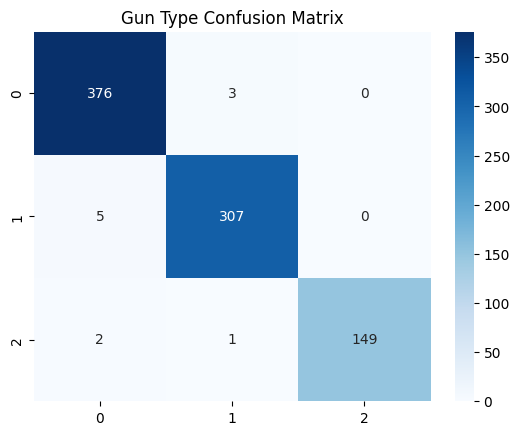

In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix for gun type classification
cm_gun = confusion_matrix(y_gun_test, gun_type_pred)
sns.heatmap(cm_gun, annot=True, fmt='d', cmap='Blues')
plt.title("Gun Type Confusion Matrix")
plt.show()

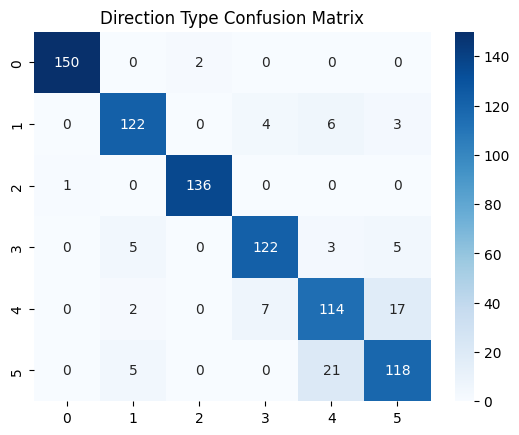

In [78]:
cm_direction = confusion_matrix(y_dir_test, direction_type_pred)
sns.heatmap(cm_direction, annot=True, fmt='d', cmap='Blues')
plt.title("Direction Type Confusion Matrix")
plt.show()

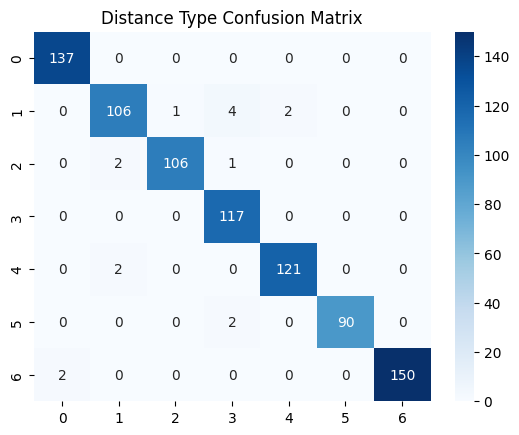

In [79]:
cm_distance = confusion_matrix(y_dist_test, distance_type_pred)
sns.heatmap(cm_distance, annot=True, fmt='d', cmap='Blues')
plt.title("Distance Type Confusion Matrix")
plt.show()

In [46]:
import plotly.graph_objects as go
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['gunshot_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_gunshot_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for gunshot feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 640x480 with 0 Axes>

In [47]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['direction_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_direction_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for direction feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 640x480 with 0 Axes>

In [48]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['distance_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_distance_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for distance feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 640x480 with 0 Axes>

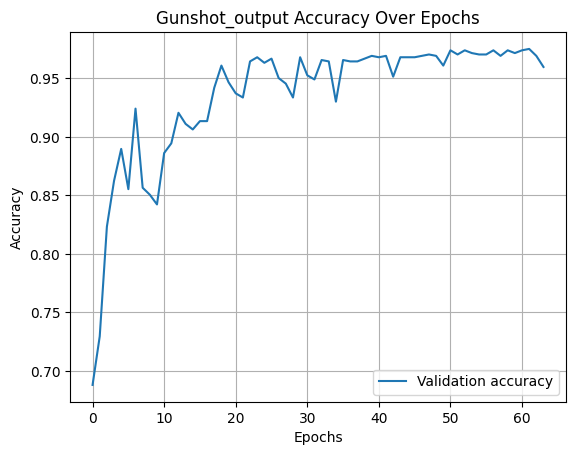

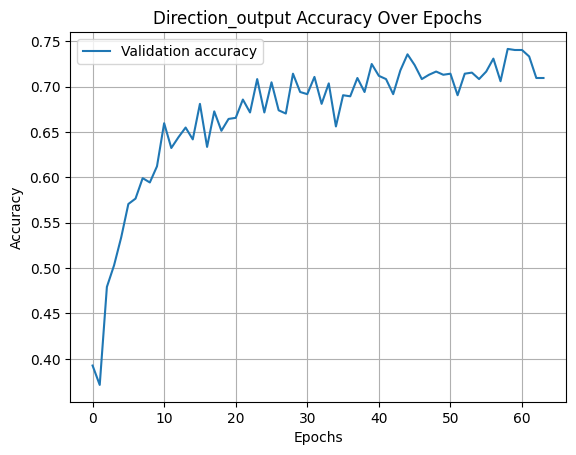

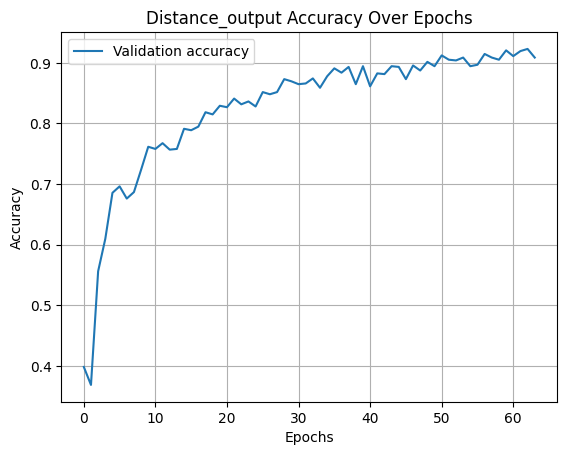

In [50]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    metrics = ["accuracy"]
    for metric in metrics:

        plt.plot(
            history.history[f"val_{model_name}_{metric}"],
            label=f"Validation {metric}",
        )
        plt.title(f"{model_name.capitalize()} {metric.capitalize()} Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid()
        plt.show()

# Plot training history for each output of the neural network
plot_training_history(history, "gunshot_output")
plot_training_history(history, "direction_output")
plot_training_history(history, "distance_output")


In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('model1.csv', index=False)